# Matplotlib and pylab inline

In [10]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [176]:
import cv2 as cv
import matplotlib.pyplot as plt

from matplotlib import rcParams

from modules.reading import *
from modules.standardization import standardize_image
from skimage.filters.rank import enhance_contrast_percentile
from skimage.morphology import disk

rcParams["figure.dpi"] = 100
rcParams["figure.figsize"] = (4, 5)
rcParams["image.cmap"] = "gray"

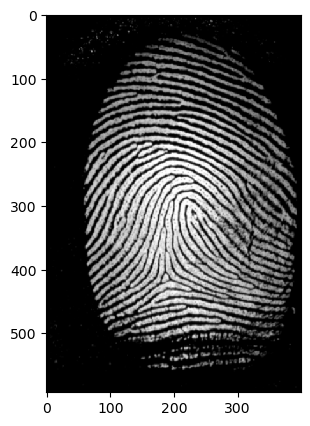

In [171]:
im = read_random_image(RAW_FILE_PATH_SCANS)
std_im = standardize_image(im)

plt.imshow(std_im)
pass

In [177]:
def get_second_derivative(im, ksize=3):
    gxx = cv.Sobel(im, cv.CV_64F, 2, 0, ksize=ksize)
    gxy = cv.Sobel(im, cv.CV_64F, 1, 1, ksize=ksize)
    gyy = cv.Sobel(im, cv.CV_64F, 0, 2, ksize=ksize)
    
    return gxx, gxy, gyy

In [178]:
def coherence_filter(im, sigma = 15, str_sigma = 15, blend = 0.5, n_iter = 5):
    
    h, w = im.shape[:2]

    for i in range(n_iter):
        eigen = cv.cornerEigenValsAndVecs(im, str_sigma, 3)
        eigen = eigen.reshape(h, w, 3, 2)  # [[e1, e2], v1, v2]
        
        x, y = eigen[:,:,1,0], eigen[:,:,1,1]

        gxx, gxy, gyy = get_second_derivative(im, sigma)
        gvv = x*x*gxx + 2*x*y*gxy + y*y*gyy
        
        m = gvv < 0

        ero = cv.erode(im, None)
        dil = cv.dilate(im, None)
        im1 = ero
        im1[m] = dil[m]
        im = np.uint8(im*(1.0 - blend) + im1*blend)

    return im

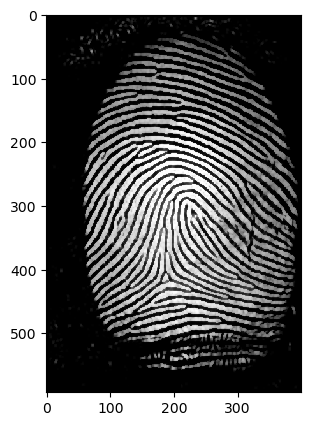

In [179]:
coh_image = coherence_filter(std_im, n_iter=2) 

plt.imshow(coh_image);

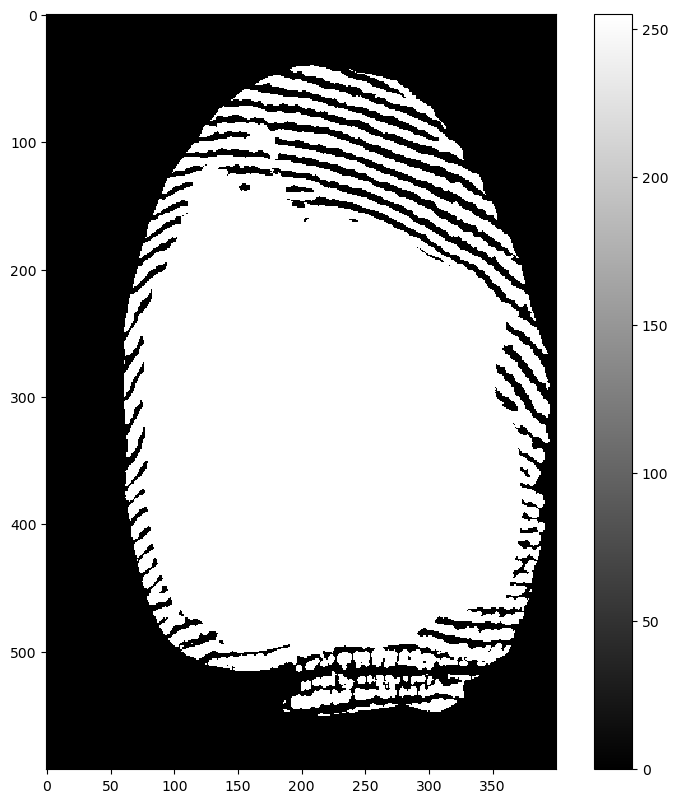

In [195]:
disk_im = disk(20)
ecnh_im = enhance_contrast_percentile(std_im, disk_im, p0=0.1, p1=.5)
thresh = cv.threshold(ecnh_im, 0, 255, cv.THRESH_BINARY)[1]

plt.figure(figsize=(10, 10))
plt.imshow(thresh)
plt.colorbar()